# Neural Network Training

In [1]:
import matplotlib.pyplot as plt

import torch.optim as optim
import numpy as np
import jax.numpy as jnp

from extravaganza.dynamical_systems import LinearRegression, MNIST

from extravaganza.lifters import NoLift, RandomLift, LearnedLift
from extravaganza.sysid import SysID
from extravaganza.controllers import LiftedBPC, ConstantController
from extravaganza.rescalers import ADAM, D_ADAM, DoWG
from experiments import run_experiment, ylim

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = None
CONTROLLER_SEED = None
LIFTER_AND_SYSID_SEED = None

## System
Here, we tune the parameters of a gradient descent algorithm training a neural network. We can train either a linear regression or an MLP or CNN MNIST model. Any optimizer can be used, such as `SGD` or `Adam`, and any parameter can be tuned, such as `lr` or `momentum`. 

Which optimizer to use is specified in the `make_optimizer` argument, and how to update and tune things is specified in the `apply_control` argument

## Hyperparameters

In [2]:
# --------------------------------------------------------------------------------------
# ------------------------    EXPERIMENT HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

num_trials = 1
T = 15000  # total timesteps
T0 = 7500  # number of timesteps to just sysid for our methods
reset_every = 1000  # how often to reset the system
wordy = True  # whether to print some things

# --------------------------------------------------------------------------------------
# --------------------------    SYSTEM HYPERPARAMETERS    ------------------------------
# --------------------------------------------------------------------------------------

du = 1
initial_lr = 0.2
make_optimizer = lambda model: optim.SGD(model.parameters(), lr=initial_lr)
def apply_control(control, system): system.opt.param_groups[0]['lr'] = initial_lr * 1.2 ** np.clip(control.item(), -5, 5)

# make_system = lambda : LinearRegression(make_optimizer, apply_control,
#                                         dataset = 'generated', 
#                                         eval_every=1, seed=SYSTEM_SEED)

make_system = lambda : MNIST(make_optimizer, apply_control,
                             model_type = 'MLP', batch_size = 64,
                             eval_every=None, seed=SYSTEM_SEED)

# --------------------------------------------------------------------------------------
# ------------------------    LIFT/SYSID HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

sysid_method = 'regression'
sysid_scale = 0.2

learned_lift_args = {
    'lift_lr': 0.001,
    'sysid_lr': 0.001,
    'cost_lr': 0.001,
    'depth': 5,
    'buffer_maxlen': int(1e6),
    'num_epochs': 200,
    'batch_size': 64,
    'seed': LIFTER_AND_SYSID_SEED
}

# --------------------------------------------------------------------------------------
# ------------------------    CONTROLLER HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

h = 20  # controller memory length (# of w's to use on inference)
hh = 20  # history length of the cost/control histories
lift_dim = 20  # dimension to lift to

m_update_rescaler = lambda : ADAM(0.002, betas=(0.9, 0.999))
m0_update_rescaler = lambda : ADAM(0.002, betas=(0.9, 0.999))
k_update_rescaler = lambda : ADAM(0.00, betas=(0.9, 0.999))

lifted_bpc_args = {
    'h': h,
    'method': 'FKM',
    'initial_scales': (0.2, 0.2, 0.0),  # M, M0, K   (uses M0's scale for REINFORCE)
    'rescalers': (m_update_rescaler, m0_update_rescaler, k_update_rescaler),
    'T0': T0,
    'bounds': (-5, 5),
    'initial_u': jnp.zeros(du),
    'decay_scales': True,
    'use_sigmoid': False,
    'use_K_from_sysid': True,
    'seed': CONTROLLER_SEED
}

make_controllers = {
#     'Zero': lambda sys: ConstantController(0, du),
#     'No Lift': lambda sys: LiftedBPC(lifter=NoLift(hh, du, LIFTER_AND_SYSID_SEED), sysid=SysID(sysid_method, du, hh, sysid_scale, LIFTER_AND_SYSID_SEED), **lifted_bpc_args),
#     'Random Lift': lambda sys: LiftedBPC(lifter=RandomLift(hh, du, lift_dim, learned_lift_args['depth'], LIFTER_AND_SYSID_SEED), sysid=SysID(sysid_method, du, lift_dim, sysid_scale, LIFTER_AND_SYSID_SEED), **lifted_bpc_args),
    'Learned Lift': lambda sys: LiftedBPC(lifter=LearnedLift(hh, du, lift_dim, scale=sysid_scale, **learned_lift_args), **lifted_bpc_args)
}

## Plotting
We keep track of the useful information through `Stats` objects, which can `register()` a variable to keep track of (which it does via calls to `update()`) and which can be aggregated via `Stats.aggregate()` for mean and variance statistics. 

We define below a plotting arrangement that plots all the desired quantities from both the system and controller.

In [3]:
def plot_nn(all_stats):
    # clear plot and calc nrows
    plt.clf()
    n = 4
    nrows = n + (len(all_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 4 * nrows))

    # plot system and controller stats
    for i, (method, stats) in enumerate(all_stats.items()):
        if stats is None: 
            print('WARNING: {} had no stats'.format(method))
            continue
        stats.plot(ax[0, 0], 'lrs', label=method)
#         stats.plot(ax[0, 1], 'ws', label=method)
        stats.plot(ax[1, 0], 'train losses', label=method)
        stats.plot(ax[1, 1], 'val losses', label=method)
    
        stats.plot(ax[2, 0], '||A||_op', label=method)
        stats.plot(ax[2, 1], '||B||_F', label=method)
        stats.plot(ax[3, 0], '||A-BK||_op', label=method)
        stats.plot(ax[3, 1], 'lifter losses', label=method)
        i_ax = ax[n + i // 2, i % 2]
        stats.plot(ax[0, 1], 'disturbances', label=method)
        stats.plot(i_ax, 'K @ state', label='K @ state')
        stats.plot(i_ax, 'M \cdot w', label='M \cdot w')
        stats.plot(i_ax, 'M0', label='M0')
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()
    
    # set titles and legends and limits and such
    # (note: `ylim()` is so useful! because sometimes one thing blows up and then autoscale messes up all plots)
    _ax = ax[0, 0]; _ax.set_title('lr'); _ax.legend(); ylim(_ax, -1, 2)
    _ax = ax[0, 1]; _ax.set_title('disturbances'); _ax.legend(); ylim(_ax, -5, 5)
    _ax = ax[1, 0]; _ax.set_title('train losses'); _ax.legend(); ylim(_ax, -2, 5)
    _ax = ax[1, 1]; _ax.set_title('val losses'); _ax.legend(); ylim(_ax, -2, 5)
    
    _ax = ax[2, 0]; _ax.set_title('||A||_op'); _ax.legend()
    _ax = ax[2, 1]; _ax.set_title('||B||_F'); _ax.legend()
    
    _ax = ax[3, 0]; _ax.set_title('||A-BK||_op'); _ax.legend()
    _ax = ax[3, 1]; _ax.set_title('lifter losses'); _ax.legend()
    pass

## actually run the thing :)

--------------------------------------------------
----------------- TRIAL 0 -----------------------
--------------------------------------------------

testing Learned Lift
registering running average of costs


  0%|                                                                                                                | 0/15000 [00:00<?, ?it/s]

reset!


  7%|████▉                                                                    | 1022/15000 [00:07<01:36, 145.41it/s, control=-.0133, cost=1.06]

reset!


 14%|█████████▊                                                              | 2034/15000 [00:13<01:16, 170.51it/s, control=-.0419, cost=0.762]

reset!


 20%|██████████████▉                                                           | 3024/15000 [00:19<01:15, 157.68it/s, control=-.12, cost=0.678]

reset!


 27%|███████████████████▌                                                     | 4015/15000 [00:26<01:11, 154.12it/s, control=0.191, cost=0.553]

reset!


 33%|████████████████████████▍                                                | 5018/15000 [00:32<01:04, 154.84it/s, control=0.0373, cost=1.02]

reset!


 40%|████████████████████████████▉                                           | 6027/15000 [00:38<00:52, 170.24it/s, control=-.0603, cost=0.588]

reset!


 47%|██████████████████████████████████▏                                      | 7033/15000 [00:44<00:47, 167.31it/s, control=-.111, cost=0.449]

reset!


 50%|███████████████████████████████████▉                                    | 7489/15000 [00:47<00:48, 154.07it/s, control=0.0438, cost=0.177]

copying the K from <extravaganza.lifters.LearnedLift object at 0x2907a48b0>
training!
mean loss for past 25 epochs was 0.0012135248724371194
mean loss for past 25 epochs was 5.43683778232662e-06
mean loss for past 25 epochs was 2.7112248881167034e-06


 50%|███████████████████████████████████▉                                    | 7489/15000 [01:00<00:48, 154.07it/s, control=0.0438, cost=0.177]

mean loss for past 25 epochs was 3.491929010124295e-06
mean loss for past 25 epochs was 1.5089135058588e-06
mean loss for past 25 epochs was 1.4135439050733111e-06
mean loss for past 25 epochs was 2.1322647967281227e-06
mean loss for past 25 epochs was 1.6200365780605352e-06
solving DARE with unconstrained Q
||A||_op = 1.0443713665008545     ||B||_F 0.8552927374839783         ||A-BK||_op = 0.9907352924346924


 53%|██████████████████████████████████████████▏                                    | 8013/15000 [01:26<01:21, 85.93it/s, control=5, cost=1.41]

reset!


 60%|███████████████████████████████████████████████▍                               | 9014/15000 [01:39<01:14, 79.99it/s, control=5, cost=2.08]

reset!


 67%|████████████████████████████████████████████████████                          | 10013/15000 [01:52<01:03, 78.88it/s, control=5, cost=2.88]

reset!


 73%|█████████████████████████████████████████████████████████▎                    | 11012/15000 [02:05<00:52, 75.57it/s, control=5, cost=7.56]

reset!


 80%|██████████████████████████████████████████████████████████████▍               | 12010/15000 [02:18<00:49, 60.17it/s, control=5, cost=2.05]

reset!


 87%|███████████████████████████████████████████████████████████████████▋          | 13014/15000 [02:31<00:25, 77.79it/s, control=5, cost=1.64]

reset!


 93%|██████████████████████████████████████████████████████████████████████     | 14010/15000 [02:45<00:12, 77.47it/s, control=-2.22, cost=1.6]

reset!


100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [02:58<00:00, 84.07it/s, control=5, cost=0.0724]


<Figure size 640x480 with 0 Axes>

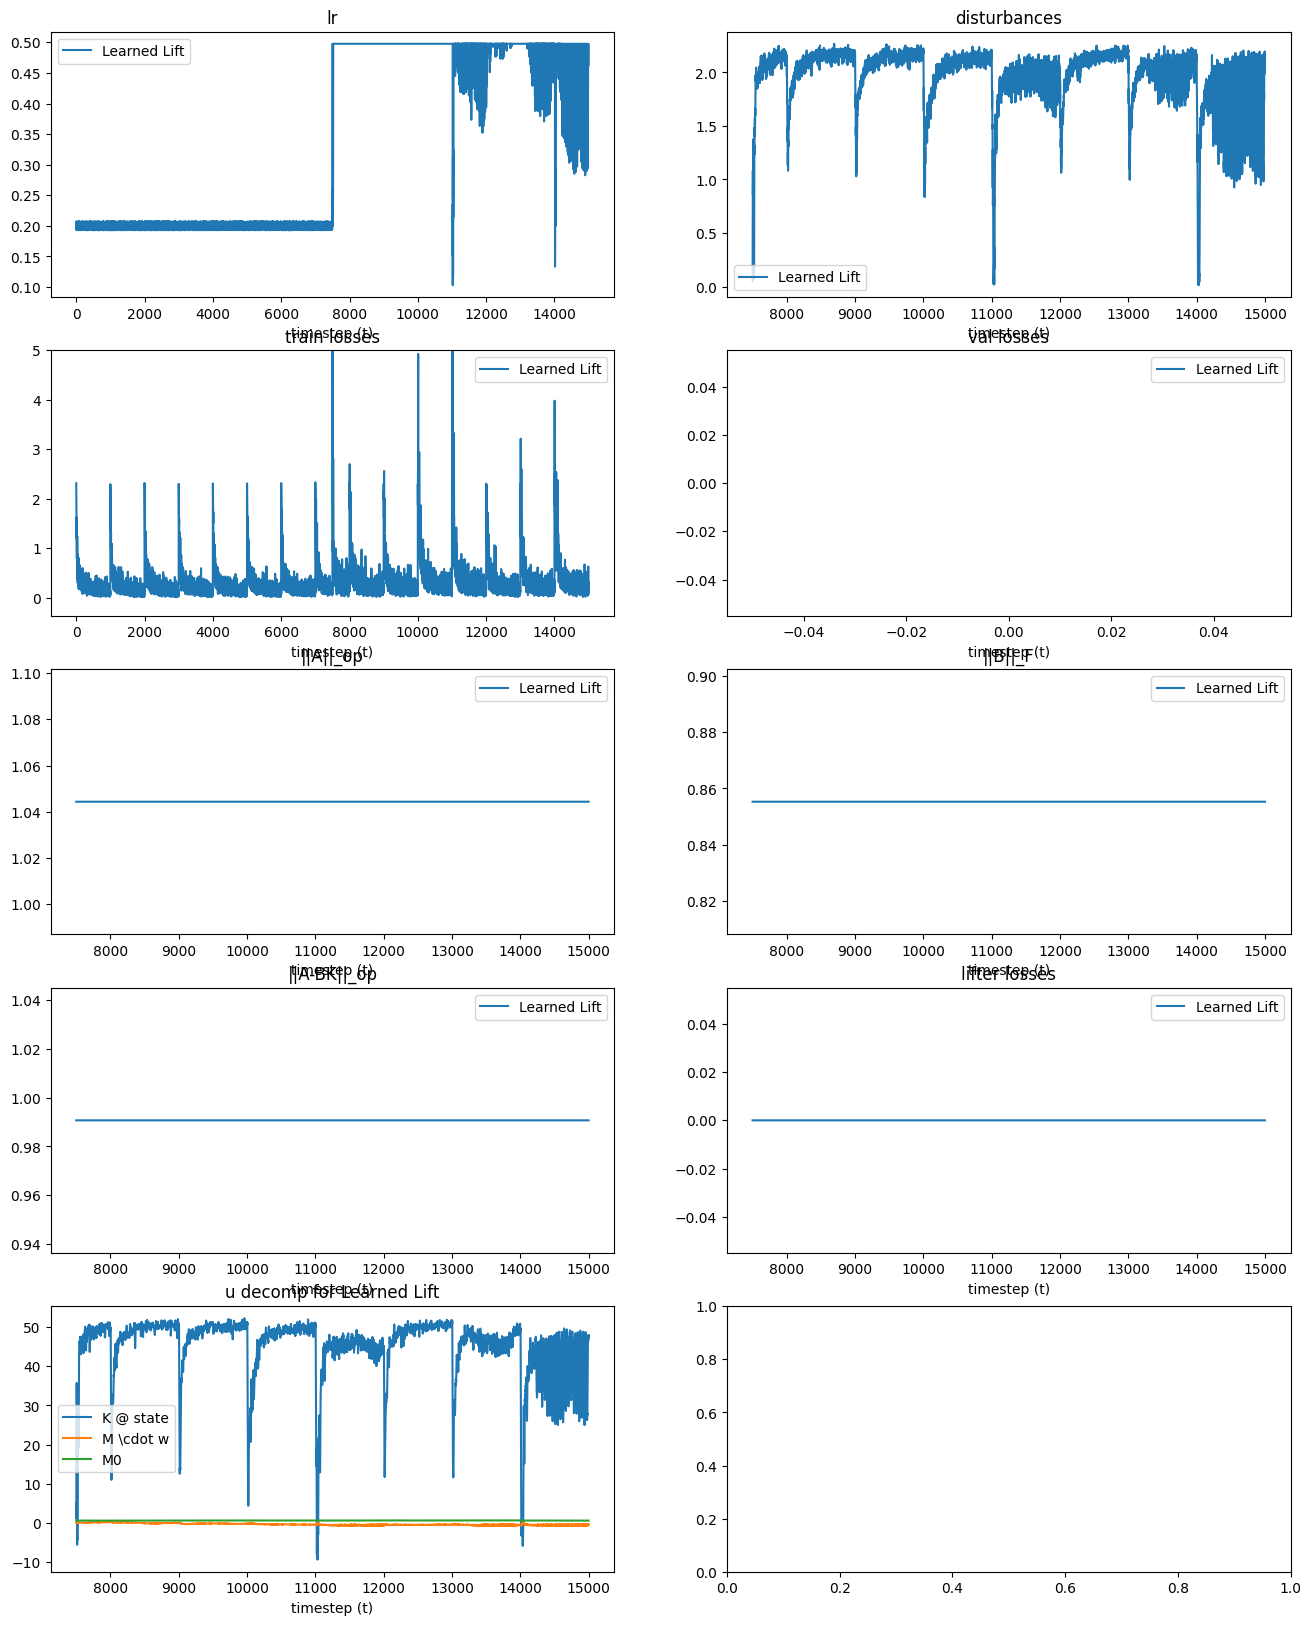

In [4]:
experiment_args = {
    'make_system': make_system,
    'make_controllers': make_controllers,
    'num_trials': num_trials,
    'T': T,
    'reset_every': reset_every,
    'reset_seed': SYSTEM_SEED,
    'wordy': wordy,
    
}
stats = run_experiment(**experiment_args)
plot_nn(stats)